In [110]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import sys
sys.path.append("../")

In [112]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [113]:
from utils import create_mask as cm
from simulations.wrapper import simulator
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF
from utils.templates import get_NFW2_template
from sbi import utils
from operator import itemgetter

## Dataset configurations

In [114]:
r_outer = 25

In [115]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [116]:
hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = r_outer)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [117]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [132]:
# Load templates

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp / np.mean(fermi_exp)

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

# temp_gce = np.load("../data/fermi_data/template_gce.npy")
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

# Load Model A templates
temp_mA_pibrem = hp.ud_grade(np.load('../data/external/template_Api.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/external/template_Aic.npy'), nside_out=128, power=-2)

# Load Model F templates
temp_mF_pibrem = hp.ud_grade(np.load('../data/external/template_Fpi.npy'), nside_out=128, power=-2)
temp_mF_ics = hp.ud_grade(np.load('../data/external/template_Fic.npy'), nside_out=128, power=-2)

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=r_outer)

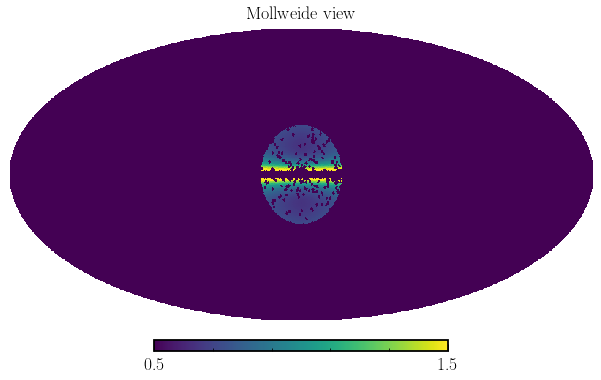

In [133]:
temp_dsk_new = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_0.3.npy'), nside_out=128, power=-2)
temp_dsk_old = hp.ud_grade(np.load('../data/external/template_disk_r_s_5_z_s_1.npy'), nside_out=128, power=-2)
hp.mollview(~roi_mask * (temp_dsk_new / temp_dsk_old), max=1.5, min=0.5)

In [134]:
n_samples = 10

In [135]:
def save_files(data_map, aux, theta, sample_name):
    np.save("../data/samples/x_{}.npy".format(sample_name), data_map)
    np.save("../data/samples/x_aux_{}.npy".format(sample_name), aux)
    np.save("../data/samples/theta_{}.npy".format(sample_name), theta)

## Model O

### PS only

In [138]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.000] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [139]:
save_files(data_map, aux, thetas, "ModelO_PS_only")

In [140]:
def dnds_conv(s_ary, theta,):
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    return dnds_ary

s_ary = np.logspace(-1, 2, 100)
s_ary[np.argmax(dnds_conv(s_ary, [1.4, 14.8947, 1.5803, -3.5917, 11.3354,  2.3185],))]

2.31012970008316

### DM only

In [144]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [145]:
save_files(data_map, aux, thetas, "ModelO_DM_only")

## Thick disk

In [146]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk_thk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [147]:
save_files(data_map, aux, thetas, "ModelO_thick_disk_DM_only")

In [162]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([0.] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk_thk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

save_files(data_map, aux, thetas, "ModelO_thick_disk_PS_only")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

## Model A

### PS only

In [163]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [1.4, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([0.] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [164]:
save_files(data_map, aux, thetas, "ModelA_PS_only")

### DM only

In [150]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([1.4] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.4] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [151]:
save_files(data_map, aux, thetas, "ModelA_DM_only")

## Mismodeling

In [152]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [154]:
nside = 128

mO_mismo = np.load("../../fermi-gce-gp/data/mO_mismo_samples.npy") 
mO_mismo /= np.expand_dims(np.mean(mO_mismo, axis=1), 1)
mismo_func = np.zeros((mO_mismo.shape[0], hp.nside2npix(nside)))
mismo_func[:, ~roi_mask] = mO_mismo

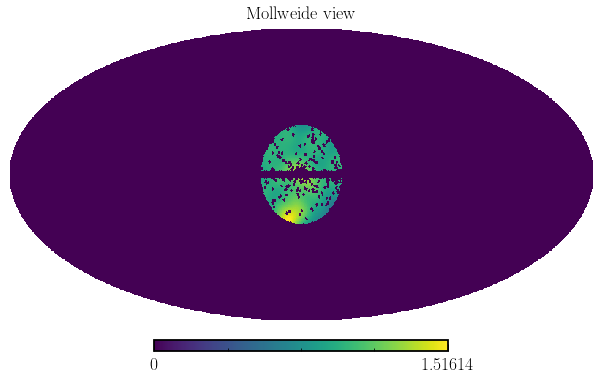

In [155]:
hp.mollview(~roi_mask * mismo_func[330])

In [156]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([1.] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([1.] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = []
for i, theta in enumerate(thetas):
    temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, mismo_func[i] * temp_mO_pibrem, temp_mO_ics]
    temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]
    maps.append(simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp))

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

In [157]:
save_files(data_map, aux, thetas, "ModelO_DM_only_mismo")

In [165]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[1., 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [1., 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([0.] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

maps = []
for i, theta in enumerate(thetas):
    temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, mismo_func[i] * temp_mO_pibrem, temp_mO_ics]
    temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]
    maps.append(simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp))

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

save_files(data_map, aux, thetas, "ModelO_PS_only_mismo")

In [69]:
from pylab import arange, show, cm

cmap = cm.RdBu_r
cmap.set_under('w')
cmap.set_bad('w')

rpm = []
for i in range(5):
    m = hp.ma(mismo_func[i])
    m.mask = roi_mask

    rpm.append(hp.cartview(m, min=0.5, max=1.5, lonra=[-25, 25], latra=[-25, 25], return_projected_map=True, cmap=cmap, title="Data-driven mismodeling"));
    rpm[i].mask = (rpm[i].data == 0)
    plt.close()

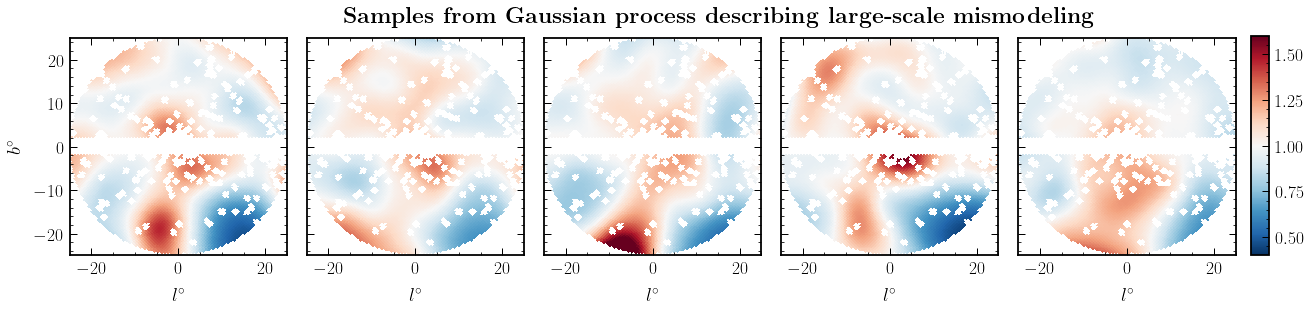

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(25, 4), sharey=True)

for i in range(5):
    im = ax[i].imshow(rpm[i], cmap=cmap, origin='lower', vmin=0.4, vmax=1.6, extent=[-25, 25, -25, 25],)
    ax[i].set_xlabel("$l^\circ$")
    if i == 0:
        ax[i].set_ylabel("$b^\circ$")

fig.subplots_adjust(right=0.8, wspace=-0.11)
cbar_ax = fig.add_axes([0.795, 0.125, 0.01, 0.763])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle(r"\bf{Samples from Gaussian process describing large-scale mismodeling}", fontsize=23, y=0.99)

plt.savefig("../paper/plots/dd_mismo_map.pdf", bbox_inches='tight')

## Asymmetric DM

In [158]:
from utils import create_mask as cm

roi_mask_N = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=0, b_mask=True, b_deg_min=0, mask_ring=True, inner=0, outer=r_outer)
roi_mask_S = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=0, b_mask=True, b_deg_max=0, mask_ring=True, inner=0, outer=r_outer)

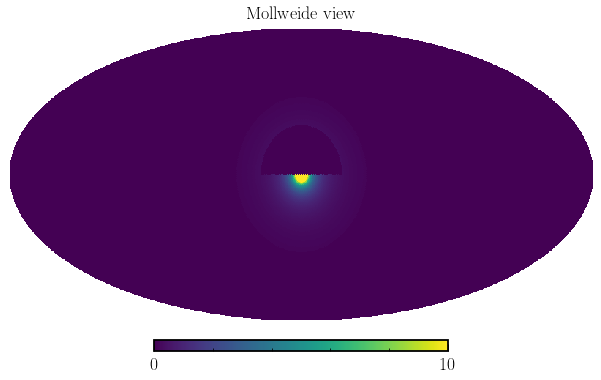

In [159]:
hp.mollview(temp_gce * roi_mask_N, max=10)

In [160]:
# iso, bub, psc, dif
prior_poiss = [[0.3949,  0.9036,  0.7301,  7.8392,  3.7726], [0.3949,  0.9036,  0.7301,  7.8392,  3.7726]]

# gce, dsk        
prior_ps = [[0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042], 
            [0.0001, 15.1300, 1.5885, -3.7377, 10.8572,  2.4219,  0.8846, 14.8976,  1.5632, -4.1816, 16.3504,  2.7042]]

prior = utils.BoxUniform(low=torch.tensor([2 * 1.2 / 3, 4 * 1.2 / 3] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2 * 1.2 / 3, 4 * 1.2 / 3] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((n_samples,))

temps_poiss_sim = [temp_gce * roi_mask_N, temp_gce * roi_mask_S, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce / rescale, temp_dsk / rescale]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func, fermi_exp) for theta in tqdm_notebook(thetas)]

data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/10 [00:00<?, ?it/s]

In [161]:
save_files(data_map, aux, thetas, "ModelO_DM_asym")